# Jupyter notebook sample

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Introduction
Finding the optimum time to go to the gym. There's historical time series data about how busy the college gym has been on a 10 minute basis available. We'll find out the best days and times to go to the gym



In [2]:
gym_data = pd.read_csv('crowdness_gym_data.csv')

In [3]:
print(gym_data.shape)

(62184, 11)


In [4]:
earliest_date = gym_data['date'].min()
latest_date = gym_data['date'].max()

print(f"Earliest date: {earliest_date}")
print(f"Latest date: {latest_date}")

Earliest date: 2015-08-14 17:00:11-07:00
Latest date: 2017-03-18 19:22:51-07:00


In [5]:
# List all unique timezones in the 'date' column
timezones = gym_data['date'].str.extract(r'([+-]\d{2}:\d{2})')[0].unique()
print("Timezones:", timezones)

Timezones: ['-07:00' '-08:00']


The timestamps indicate some daylight savings going on. Let's check that

In [6]:
# Extract the timezone from the 'date' column
gym_data['timezone'] = gym_data['date'].str.extract(r'([+-]\d{2}:\d{2})')[0]

# Detect transitions (where timezone shifts occur)
gym_data['shift'] = gym_data['timezone'] != gym_data['timezone'].shift()

# Get the specific dates where the timezone changes
timezone_shift_dates = gym_data.loc[gym_data['shift'], 'date']
print("Timezone shift dates:")
print(timezone_shift_dates)

Timezone shift dates:
0        2015-08-14 17:00:11-07:00
7638     2015-11-01 01:00:13-08:00
20601    2016-03-13 05:20:11-07:00
51172    2016-11-06 01:01:48-08:00
61519    2017-03-12 17:51:01-07:00
Name: date, dtype: object


In [7]:
# Create a datetime column from the 'date' column
gym_data['datetime'] = pd.to_datetime(gym_data['date'], utc=True)

# Timezone location
Given shifts between daylight savings time and standard time. It's matching the Pacific Time (PT) timezone. The college could be in one of 5 states in the US.
- Colorado
- Washington
- Nevada
- Oregon (in certain areas)
- Idaho (in pan handle)

Idaho and Oregon don't universally observe DST, because of their geography. Most of Idaho is in Mountain Time (MT) and there is only one college in the PT section of Idaho, and only one college in the MT section of Oregon. So it is likely the college gym data comes from Colorado, Washington, Nevada or Oregon.

# Data structure
The dataframe contains 12 columns and about 62184 observations that start mid August 2015 and go to March 2017, but there's clearly some missing data from the start of January 2017 to March 2017 we'll need to address. Finding the start of semester and during semester times is also fairly trivial to perform if we can look up the college semester dates for those years. In this case though, we don't know which college this gym is located at, so we'll need to extract that from existing fields

The real data that's valuable in this data set is the three columns
`number_people`, `date`, `temperature`

Many of the columns are helpful as splitting out data from the date column. We could generate day of week, weekend, holiday, month, hour trivially from the date column. See below
```
# Create new columns from the 'datetime' column
import datetime as dt

gym_data['timestamp'] = gym_data['datetime'].dt.hour * 3600 + gym_data['datetime'].dt.minute * 60 + gym_data['datetime'].dt.second
gym_data['dayofweek'] = gym_data['datetime'].dt.dayofweek
gym_data['is_weekend'] = gym_data['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
gym_data['month'] = gym_data['datetime'].dt.month
gym_data['hour'] = gym_data['datetime'].dt.hour
```


- **`number_people`**: this is the number of people at the gym at each observation. This will be our target variable or label.
- **`date`**: a string value with the specific date and time information.
- **`timestamp`**: an integer (int), with the number of seconds since the start of the day (00:00).
- **`dayofweek`**: an integer (int). 0 is equal to Monday and 6 is equal to Sunday.
- **`is_weekend`**: a Boolean value defining if this observation happened during a weekend. 1 for yes, 0 for no.
- **`is_holiday`**: a Boolean value defining if the observation happened during a holiday. 1 for yes, 0 for no.
- **`temperature`**: a float, defining the temperature during the day of the observation in Fahrenheit.
- **`is_start_of_semester`**: a Boolean defining if the observation happened in the first 2 weeks of a semester. 1 for yes, 0 for no.
- **`is_during_semester`**: a Boolean defining if the observation happened during the active semester. 1 for yes, 0 for no.
- **`month`**: an integer (int) defining the month of the year. 1 is equal to January, 12 is equal to December.
- **`hour`**: an integer (int) for the hour of the day from 0 to 23.

## Semesters
First let's find the start, end and durations of the semesters. This will be important for our analysis, as this is a college gym, many students will return home out of semester time, so gym attendance will drop when they aren't around.

In [8]:
# Resample to daily frequency to get only one observation per day
daily_gym_data = gym_data.resample('D', on='datetime').first()

# Detect start of semesters - the first entry that is true in a series of true.
semester_start_dates = daily_gym_data[
    (daily_gym_data['is_start_of_semester'] == True) &
    (daily_gym_data['is_start_of_semester'].shift(1) != True)
].index


In [9]:
# Calculate semester durations
# The end of the semester is when is_during_semester switches from true to false
semester_durations = []

# Create an object to store semester start and end dates
semester_intervals = []

for start_date in semester_start_dates:
    # Ensure the 'is_during_semester' column is boolean
    is_during_mask = (daily_gym_data.index >= start_date) & (daily_gym_data['is_during_semester'].astype(bool))

    # Find the last day when is_during_semester is True after the start date
    semester_end_date = daily_gym_data[is_during_mask & ~daily_gym_data['is_during_semester'].shift(-1).astype(bool)].index
    if not semester_end_date.empty:
        start = start_date.tz_convert('US/Pacific')  # Convert to Pacific Time
        end = semester_end_date[0].tz_convert('US/Pacific')  # Convert to Pacific Time
        duration = (end - start).days
        semester_durations.append({
            'year': start.year,
            'start_date': start,
            'end_date': end,
            'duration_days': duration
        })

        # Append the start and end dates to the intervals object
        semester_intervals.append((start, end))

# Add a semester in 2015 that mirrors the 2016 January to May semester programmatically
jan_may_2016_start = semester_durations[1]['start_date']  # 2016 January start
duration_days = semester_durations[1]['duration_days']  # 2016 semester duration

# Calculate the mirrored 2015 semester start and end dates
jan_may_2015_start = jan_may_2016_start.replace(year=2015)
jan_may_2015_end = jan_may_2015_start + pd.Timedelta(days=duration_days)

# Convert the new semester's timestamps to Pacific Time
jan_may_2015_start = jan_may_2015_start.tz_convert('US/Pacific')
jan_may_2015_end = jan_may_2015_end.tz_convert('US/Pacific')

# Add the new semester to the list
semester_durations.insert(1, {
    'year': 2015,
    'start_date': jan_may_2015_start,
    'end_date': jan_may_2015_end,
    'duration_days': duration_days
})
semester_intervals.insert(1, (jan_may_2015_start, jan_may_2015_end))

# Forecast the 2017 semester dates programmatically based on the 2016 semesters
for semester in semester_durations:
    if semester['year'] == 2016:
        start_2017 = semester['start_date'].replace(year=2017)
        end_2017 = semester['end_date'].replace(year=2017)

        # Add the forecasted 2017 semesters to the list
        semester_durations.append({
            'year': 2017,
            'start_date': start_2017,
            'end_date': end_2017,
            'duration_days': semester['duration_days']
        })
        semester_intervals.append((start_2017, end_2017))

# semester_durations can be used for detailed information
# semester_intervals can be used to add features to graphs
semester_durations, semester_intervals

([{'year': 2015,
   'start_date': Timestamp('2015-08-26 17:00:00-0700', tz='US/Pacific'),
   'end_date': Timestamp('2015-12-18 16:00:00-0800', tz='US/Pacific'),
   'duration_days': 114},
  {'year': 2015,
   'start_date': Timestamp('2015-01-17 16:00:00-0800', tz='US/Pacific'),
   'end_date': Timestamp('2015-05-14 17:00:00-0700', tz='US/Pacific'),
   'duration_days': 117},
  {'year': 2016,
   'start_date': Timestamp('2016-01-17 16:00:00-0800', tz='US/Pacific'),
   'end_date': Timestamp('2016-05-13 17:00:00-0700', tz='US/Pacific'),
   'duration_days': 117},
  {'year': 2016,
   'start_date': Timestamp('2016-08-24 17:00:00-0700', tz='US/Pacific'),
   'end_date': Timestamp('2016-12-16 16:00:00-0800', tz='US/Pacific'),
   'duration_days': 114},
  {'year': 2017,
   'start_date': Timestamp('2017-01-17 16:00:00-0800', tz='US/Pacific'),
   'end_date': Timestamp('2017-05-13 17:00:00-0700', tz='US/Pacific'),
   'duration_days': 117},
  {'year': 2017,
   'start_date': Timestamp('2017-08-24 17:00:00-

The data covers 3 semesters. The 4th semester that would start in 2017 is missing a lot of data so we'll have to ignore it. We've also estimated the dates of the first semester in 2015

# Plotting time series data
We'll smooth the data for temperature and number of people attending. A rolling window of 144 works out to be about a 1 day average, which is good for smaller views, but still a bit busy for a yearlong view

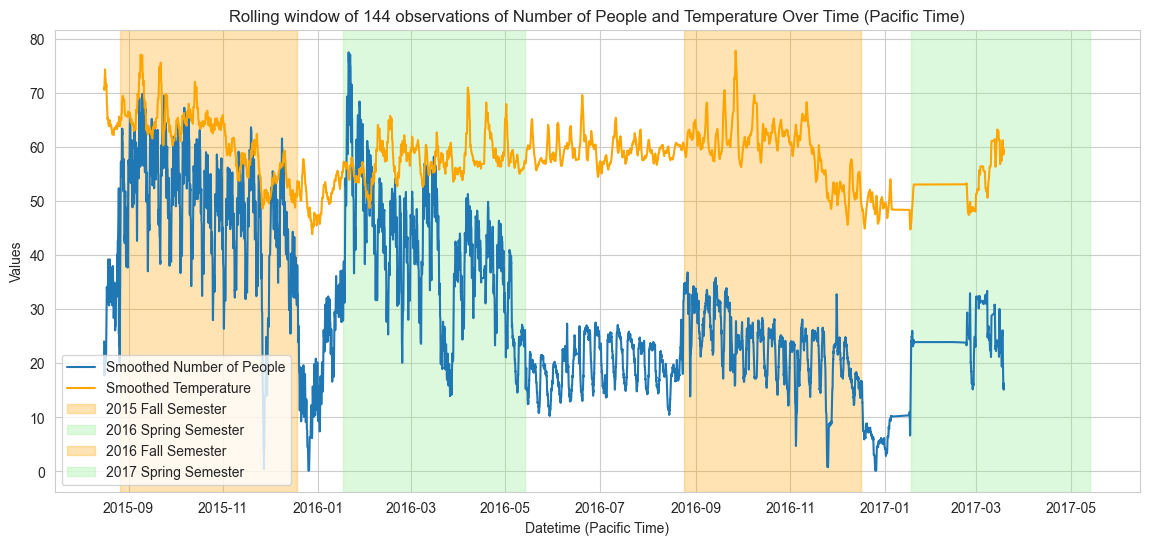

In [10]:
# Convert the 'datetime' column to Pacific Time (PT)
gym_data['datetime_pacific'] = gym_data['datetime'].dt.tz_convert('US/Pacific')

# Apply a rolling mean for smoothing
gym_data['number_people_smooth'] = gym_data['number_people'].rolling(window=144).mean()
gym_data['temperature_smooth'] = gym_data['temperature'].rolling(window=144).mean()

# Plotting the smoothed data as a function of the adjusted datetime column
plt.figure(figsize=(14, 6))
sns.lineplot(data=gym_data, x='datetime_pacific', y='number_people_smooth', label='Smoothed Number of People')
sns.lineplot(data=gym_data, x='datetime_pacific', y='temperature_smooth', label='Smoothed Temperature', color='orange')

# Define a color map for seasons
season_colors = {
    'Spring': 'lightgreen',
    'Summer': 'lightblue',
    'Fall': 'orange',
    'Winter': 'lightcoral'
}

# Helper function to determine the season
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# This calculates how many days fall in each season and returns the season with the highest count.
def get_majority_season(start, end):
    days = pd.date_range(start=start, end=end, freq='D')
    season_counts = days.month.map(get_season).value_counts()
    majority_season = season_counts.idxmax()  # Find the season with the highest count
    return majority_season

# Highlight the time periods that are semesters and label them with year and season
for start, end in semester_intervals:
    # Only draw if there is data in the given semester interval
    interval_data = gym_data[(gym_data['datetime_pacific'] >= start) & (gym_data['datetime_pacific'] <= end)]
    if not interval_data.empty:
        season = get_majority_season(start, end)
        color = season_colors[season]
        label = f'{start.year} {season} Semester'

        plt.axvspan(start.tz_convert('US/Pacific'), end.tz_convert('US/Pacific'), color=color, alpha=0.3, label=label)

plt.title('Rolling window of 144 observations of Number of People and Temperature Over Time (Pacific Time)')
plt.xlabel('Datetime (Pacific Time)')
plt.ylabel('Values')
plt.legend()
plt.show()

### Time series data
It appears from the data the gym was gradually losing people attending, and then in 2017, there was something going on, possibly renovations that prevented data collection for a few months. We observe the expected dips around the holidays, near Thanksgiving and Christmas

### Holidays
Let's check if the `is_holiday` column is giving us the right information

In [11]:
# Filter rows where 'is_holiday' is 1
holiday_dates = gym_data[gym_data['is_holiday'] == 1]['datetime'].dt.date

# Group by year and extract unique dates for holidays
holidays_per_year = holiday_dates.groupby(holiday_dates.map(lambda x: x.year)).unique()

# Display the unique holiday dates per year
for year, dates in holidays_per_year.items():
    print(f"Holidays in {year}: {list(dates)}")

Holidays in 2017: [datetime.date(2017, 1, 2), datetime.date(2017, 1, 3), datetime.date(2017, 1, 17)]


Interestingly the `is_holiday` column seems to be nonfunctional, We would expect more holidays than just those. We'll need to repair this column too.

We'll start with federal holidays. There's a good python module for this. We'll assume this is a US college for now, because we're observing a large dip at the end of november which corresponds to Thanksgiving, a US holiday. We can also assume from the timezone component being Pacific Time it's in the US as well.

```
pip install holidays
```

In [12]:
import holidays

# Initialize the US holidays
us_holidays = holidays.US()

gym_data['is_holiday_fixed'] = gym_data['datetime'].dt.date.apply(lambda x: x in us_holidays)

In [13]:
# Define state-specific holiday objects
state_holidays = {
    "CA": holidays.US(state='CA'),
    "WA": holidays.US(state='WA'),
    "NV": holidays.US(state='NV'),
    "OR": holidays.US(state='OR'),
    "ID": holidays.US(state='ID')
}

# Initialize federal holidays object
federal_holidays = holidays.US()

# Group by year and extract unique dates for holidays
holidays_fixed_per_year = gym_data[gym_data['is_holiday_fixed']]['datetime'].dt.date.groupby(
    gym_data['datetime'].dt.year
).unique()

# Create a list to store holiday data
holiday_data = []

# Generate holiday details
for year, dates in holidays_fixed_per_year.items():
    for date in dates:
        state_details = {}
        holiday_names = []

        # Check which states have this holiday and get the holiday name
        for state, state_holiday_obj in state_holidays.items():
            holiday_name = state_holiday_obj.get(date)
            state_details[state] = "Yes" if holiday_name else "No"
            if holiday_name and holiday_name not in holiday_names:
                holiday_names.append(holiday_name)

        # Check federal holiday
        federal_holiday_name = federal_holidays.get(date)
        state_details["Federal"] = "Yes" if federal_holiday_name else "No"
        if federal_holiday_name and federal_holiday_name not in holiday_names:
            holiday_names.append(federal_holiday_name)

        # Combine holiday names into a single string
        holiday_name_combined = ", ".join(holiday_names)

        # Add the date, holiday name(s), and state details to the holiday data
        holiday_data.append({
            'Date': date,
            'Holiday Name': holiday_name_combined,
            **state_details,
        })

# Convert the holiday data into a DataFrame
holiday_df = pd.DataFrame(holiday_data)

# Display the dataframe nicely using the tabulate module
from tabulate import tabulate
print(tabulate(holiday_df, headers='keys', tablefmt='pretty'))

+----+------------+-----------------------------------------------------------------------------+-----+-----+-----+-----+-----+---------+
|    |    Date    |                                Holiday Name                                 | CA  | WA  | NV  | OR  | ID  | Federal |
+----+------------+-----------------------------------------------------------------------------+-----+-----+-----+-----+-----+---------+
| 0  | 2015-09-07 |                                  Labor Day                                  | Yes | Yes | Yes | Yes | Yes |   Yes   |
| 1  | 2015-11-11 |                                Veterans Day                                 | Yes | Yes | Yes | Yes | Yes |   Yes   |
| 2  | 2015-11-26 |                                Thanksgiving                                 | Yes | Yes | Yes | Yes | Yes |   Yes   |
| 3  | 2015-12-25 |                                Christmas Day                                | Yes | Yes | Yes | Yes | Yes |   Yes   |
| 4  | 2016-01-01 |               

# Timezone and holidays
Of the potential holidays and time zones, our 4 candidate states all observe the same as federal, so we can't narrow down which state the college belongs to.

# Gym at busy periods
Let's focus our view on 2016 and look for the busiest month, week, day so we can observe and check the data makes sense

Busiest Month: 2
Busiest Week: 5
Busiest Day: 2016-02-01


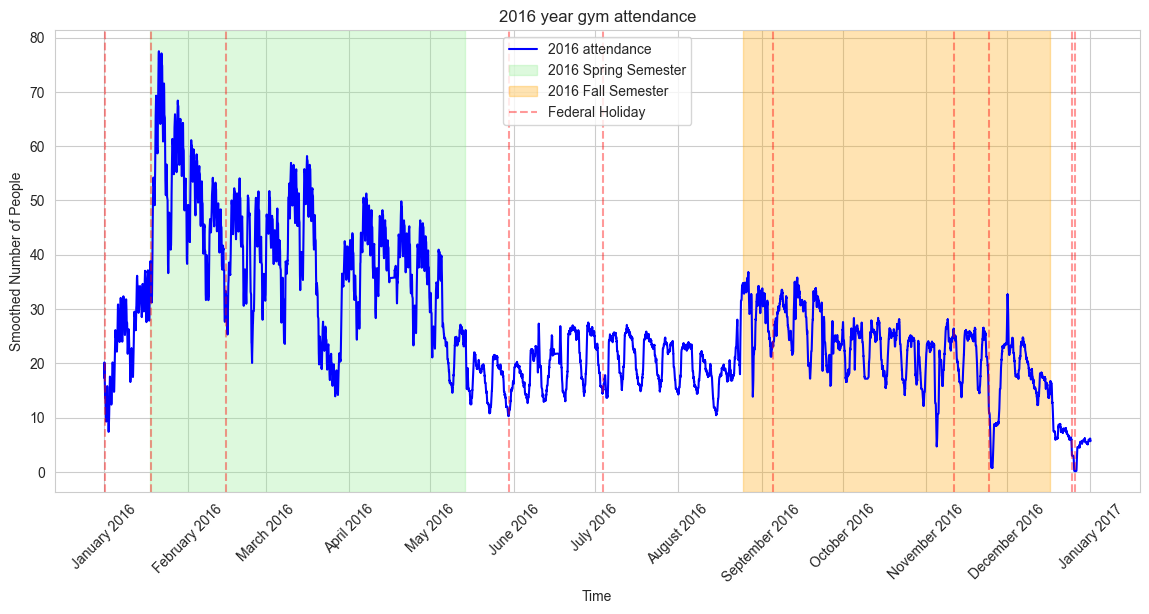

In [14]:
# Filter the dataset for the year 2016
gym_data_2016 = gym_data[gym_data['datetime'].dt.year == 2016].copy()  # Avoid SettingWithCopyWarning by using .copy()

# Apply timezone adjustment for Pacific Time before analysis
gym_data_2016['datetime_pacific'] = gym_data_2016['datetime'].dt.tz_convert('US/Pacific')

# Identify the busiest month in 2016 based on the average number of people
busiest_month = gym_data_2016.groupby(gym_data_2016['datetime_pacific'].dt.month)['number_people'].mean().idxmax()
gym_data_busiest_month = gym_data_2016[gym_data_2016['datetime_pacific'].dt.month == busiest_month].copy()  # Use .copy()

# Filter for weeks in the busiest month that have 7 whole days
gym_data_busiest_month['week'] = gym_data_busiest_month['datetime_pacific'].dt.isocalendar().week
weeks_with_7_days = gym_data_busiest_month.groupby('week').filter(lambda x: x['datetime_pacific'].dt.date.nunique() == 7).copy()  # Use .copy()

# Identify the busiest week in the busiest month with 7 days
busiest_week = weeks_with_7_days.groupby('week')['number_people'].mean().idxmax()
gym_data_busiest_week = weeks_with_7_days[weeks_with_7_days['week'] == busiest_week].copy()  # Use .copy()

# Identify the busiest day in the busiest week
busiest_day = gym_data_busiest_week.groupby(gym_data_busiest_week['datetime_pacific'].dt.date)['number_people'].mean().idxmax()
gym_data_busiest_day = gym_data_busiest_week[gym_data_busiest_week['datetime_pacific'].dt.date == busiest_day].copy()  # Use .copy()

# Display results
print(f"Busiest Month: {busiest_month}")
print(f"Busiest Week: {busiest_week}")
print(f"Busiest Day: {busiest_day}")

# Visualization for the entire year 2016 with seasons and semester overlays
plt.figure(figsize=(14, 6))
sns.lineplot(data=gym_data_2016, x='datetime_pacific', y='number_people_smooth', label='2016 attendance', color='blue')

# Highlight the time periods that are semesters and label them with year and season
for start, end in semester_intervals:
    if start.year == 2016:  # Only include semesters for 2016
        season = get_majority_season(start, end)
        color = season_colors[season]
        label = f'{start.year} {season} Semester'
        plt.axvspan(start, end, color=color, alpha=0.3, label=label)

# Draw vertical bands exclusively for federal holidays
shown_labels = []  # Track already shown labels for the legend
for holiday_date in federal_holidays.keys():
    if holiday_date.year == 2016:  # Only include holidays for 2016
        holiday_datetime = pd.Timestamp(holiday_date).tz_localize('US/Pacific')
        label = 'Federal Holiday' if 'Federal Holiday' not in shown_labels else ""
        plt.axvline(holiday_datetime, color='red', linestyle='--', alpha=0.4, label=label)
        if label:
            shown_labels.append('Federal Holiday')

plt.title('2016 year gym attendance')
plt.xlabel('Time')
plt.ylabel('Smoothed Number of People')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())  # Show every month
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%B %Y'))  # Format as month name with year
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()

# 2016 insights
The 2016 plot with holidays marked out makes sense. We can observe some trends.
- That at start of the year and semester, attendance is high, which tails off as the semester completes. The fall semester duplicates this as well, but not as much
- There is a baseline level of gym attendance, likely provided by staff and students not returning home for summer holidays
- We also observe in the latter half of march a decline in attendance, likely coinciding with midterms and spring break.

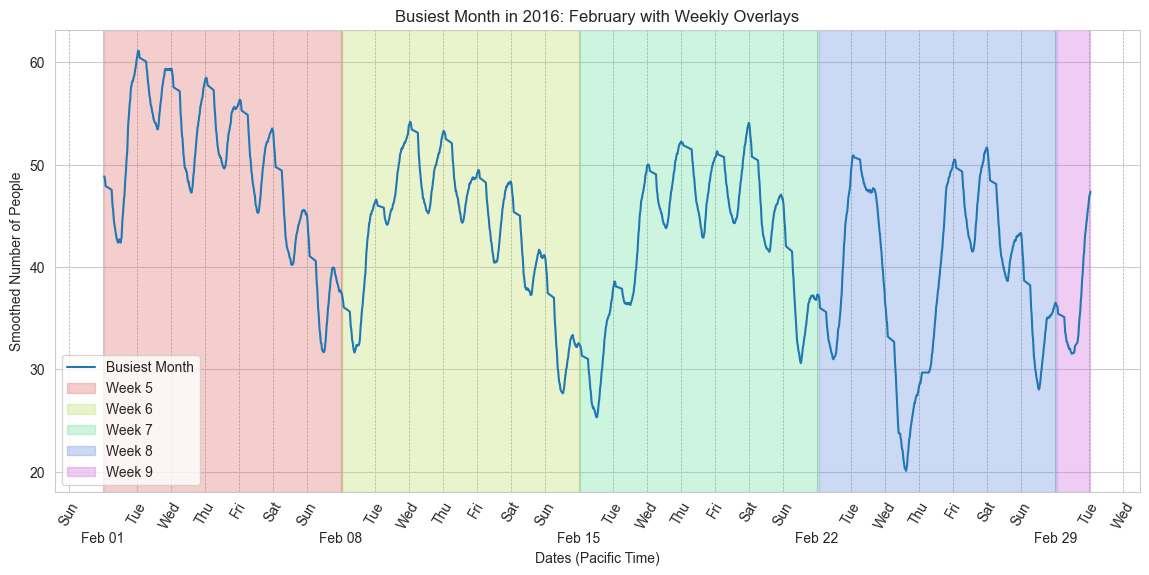

In [15]:
# Visualization for the Busiest Month
plt.figure(figsize=(14, 6))
sns.lineplot(data=gym_data_busiest_month,
             x=gym_data_busiest_month['datetime_pacific'] - pd.Timedelta(hours=7),  # Offset by timezone adjustment
             y='number_people_smooth',
             label='Busiest Month')

# Highlight different weeks with transparent overlays and alternating colors
unique_weeks = gym_data_busiest_month['datetime_pacific'].dt.isocalendar().week.unique()
colors = sns.color_palette("hls", len(unique_weeks))  # Generate unique colors

for i, week in enumerate(unique_weeks):
    week_data = gym_data_busiest_month[gym_data_busiest_month['datetime_pacific'].dt.isocalendar().week == week]
    start_date = week_data['datetime_pacific'].min() - pd.Timedelta(hours=7)  # Offset start_date
    end_date = week_data['datetime_pacific'].max() - pd.Timedelta(hours=7)  # Offset end_date
    plt.axvspan(start_date, end_date, color=colors[i], alpha=0.3, label=f'Week {week}')

# Adjust the x-axis to show correctly aligned ticks
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=7))  # Set major ticks for every 7 days
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d'))  # Format major ticks as 'Month Day'

# Add minor ticks for all 7 weekdays and ensure they display properly
plt.gca().xaxis.set_minor_locator(plt.matplotlib.dates.DayLocator())  # Set minor ticks for every day
plt.gca().xaxis.set_minor_formatter(plt.matplotlib.dates.DateFormatter('%a'))  # Format minor ticks as weekday names
plt.tick_params(axis='x', which='minor', labelrotation=60)  # Rotate minor ticks 60 degrees
plt.tick_params(axis='x', which='major', pad=25)  # Add padding to major ticks to position them further down
plt.grid(visible=True, which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # Enable minor gridlines

# Change the plot title to include the busiest month
busiest_month_name = pd.to_datetime(f'2016-{busiest_month}-01').strftime('%B')
plt.title(f'Busiest Month in 2016: {busiest_month_name} with Weekly Overlays')
plt.xlabel('Dates (Pacific Time)')
plt.ylabel('Smoothed Number of People')
plt.legend()
plt.show()

As expected, the weekly cycles of the gym indicates many people start on a monday and leave the weekends free. Interestingly, in the week of Feb 22, the Wednesday attendance was unusually low. It might correspond with a local event or examination period.

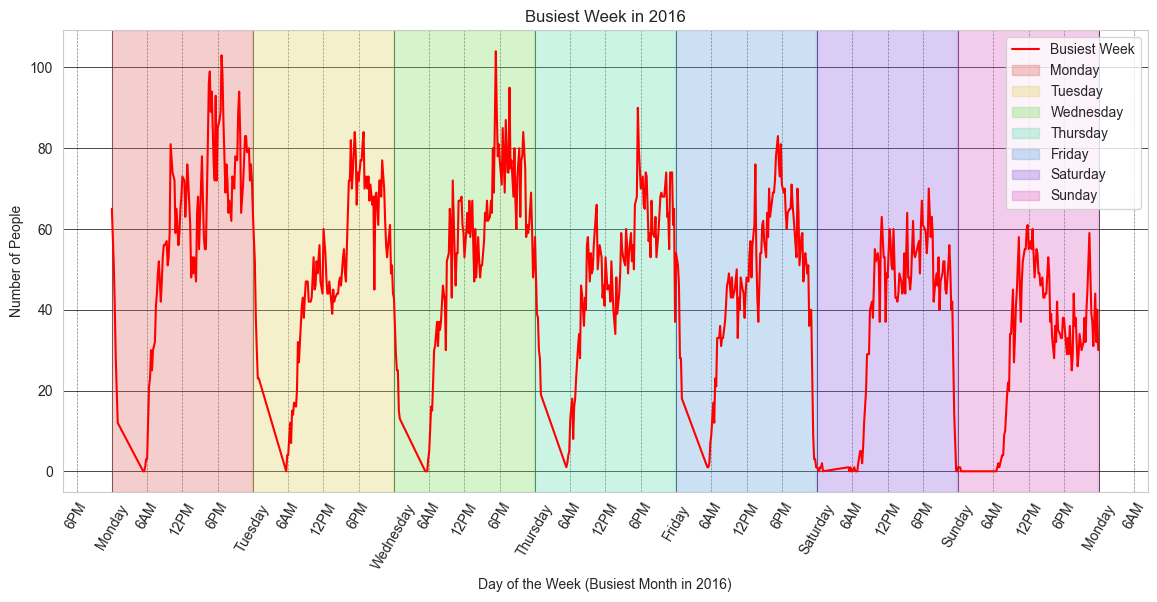

In [16]:
# Sanity check: How many people were in the gym on Saturday at 12 PM
plt.figure(figsize=(14, 6))

# Use smoothed values for better visualization
sns.lineplot(data=gym_data_busiest_week, x=gym_data_busiest_week['datetime_pacific'], y='number_people', label='Busiest Week', color='red')

# Highlight data for individual days with proper timezone awareness
unique_days = gym_data_busiest_week['datetime_pacific'].dt.normalize().unique()  # Unique normalized (midnight) date-like objects
colors = sns.color_palette("hls", len(unique_days))  #

for i, day in enumerate(unique_days):
    # Create start and end times for each day
    day_data = gym_data_busiest_week[gym_data_busiest_week['datetime_pacific'].dt.normalize() == day]
    start_time = day_data['datetime_pacific'].min()  # Proper timezone-aware start time
    end_time = day_data['datetime_pacific'].max()  # Proper timezone-aware end time
    weekday = day.strftime('%A')  # Get the weekday name
    plt.axvspan(start_time, end_time, color=colors[i], alpha=0.3, label=f'{weekday}')

plt.title('Busiest Week in 2016')
plt.xlabel('Day of the Week (Busiest Month in 2016)')
plt.ylabel('Number of People')  # Updated label

# Add major and minor ticks for the x-axis
plt.gca().xaxis.set_major_locator(
    plt.matplotlib.dates.WeekdayLocator(byweekday=range(7), tz=start_time.tz)  # Timezone-aware locator for days
)
plt.gca().xaxis.set_minor_locator(
    plt.matplotlib.dates.HourLocator(byhour=[6, 12, 18], tz=start_time.tz)  # Timezone-aware locator for hours
)

# Add gridlines for both major and minor ticks
plt.grid(which='major', color='black', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)

# Set custom labels for minor ticks
plt.gca().xaxis.set_minor_formatter(plt.matplotlib.dates.DateFormatter('%#I%p', tz=start_time.tz))  # Timezone-aware formatter

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%A', tz=start_time.tz))  # Timezone-aware formatter
plt.xticks(rotation=60)  # Rotate major x-axis labels for better readability
plt.gca().tick_params(axis='x', which='minor', rotation=60)

plt.legend()
plt.show()

As expected, there's minimal to no gym activity or data recorded between midnight and 6am. Gym activity picks up from 6am onwards each day with the evening crowd being larger than the morning crowd.

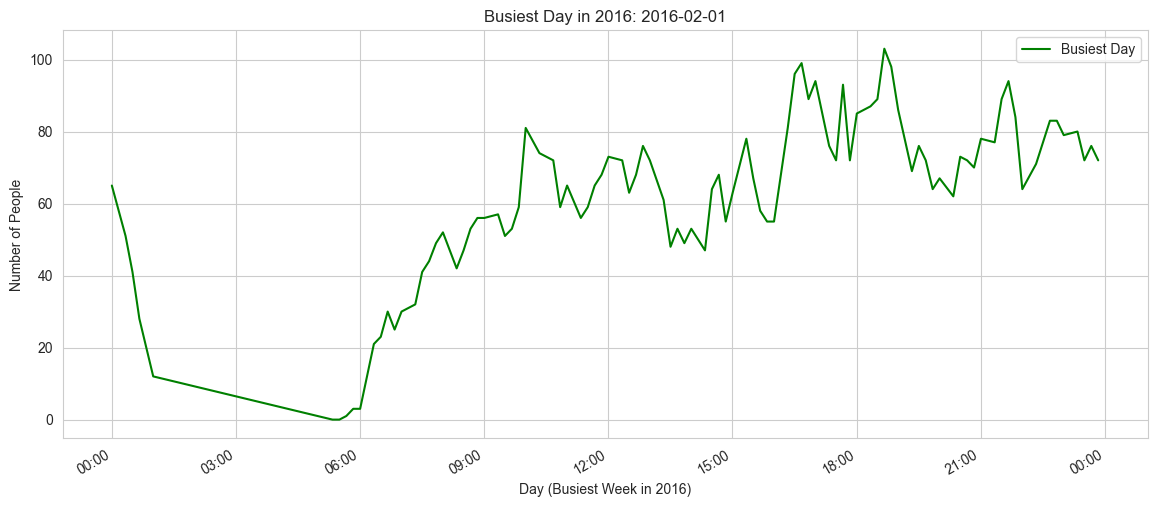

In [17]:
# Visualization for the Busiest Day
busiest_day_date = gym_data_busiest_day['datetime_pacific'].dt.date.unique()[0]  # Get the date of the busiest day
plt.figure(figsize=(14, 6))
sns.lineplot(data=gym_data_busiest_day,
             x=gym_data_busiest_day['datetime_pacific'],  # Use the timezone-aware datetime directly
             y='number_people',
             label='Busiest Day',
             color='green')
plt.title(f'Busiest Day in 2016: {busiest_day_date}')
plt.xlabel('Day (Busiest Week in 2016)')
plt.ylabel('Number of People')  # Reflect that raw data is being used
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.gcf().autofmt_xdate()  # Auto format date to show time

# Set major ticks to start at midnight and every 3 hours thereafter
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.HourLocator(byhour=range(0, 24, 3), tz=gym_data_busiest_day['datetime_pacific'].dt.tz))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M', tz=gym_data_busiest_day['datetime_pacific'].dt.tz))  # Format as HH:MM with timezone awareness

plt.legend()
plt.show()

On a given day, activity starts around 6am and continues, with a bit of an increase after 5pm

# EDA and data cleaning
We expect that `temperature` and `date` to be the two primary features. We'll keep the `is_holiday`, `isstartof_semester`, `is_during_semester` features as well, since we can't recreate those just from the `date` alone. Let's take a look at correlations for all of them first

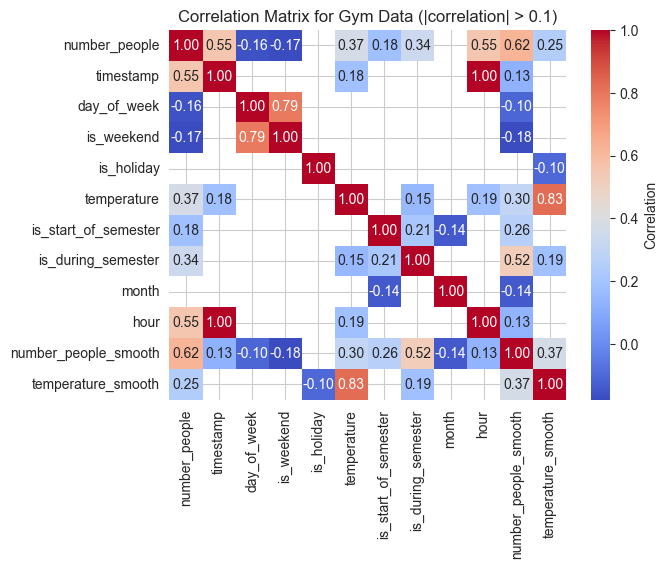

In [18]:
# Display correlation matrix of all numeric columns with correlations greater than 0.1 in absolute value
correlation_matrix = gym_data.select_dtypes(include=[np.number]).corr()

# Create a mask to filter out correlations with absolute values <= 0.1
mask = abs(correlation_matrix) <= 0.1

# Apply the mask before plotting
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask, cbar_kws={"label": "Correlation"})
plt.title('Correlation Matrix for Gym Data (|correlation| > 0.1)')
plt.show()

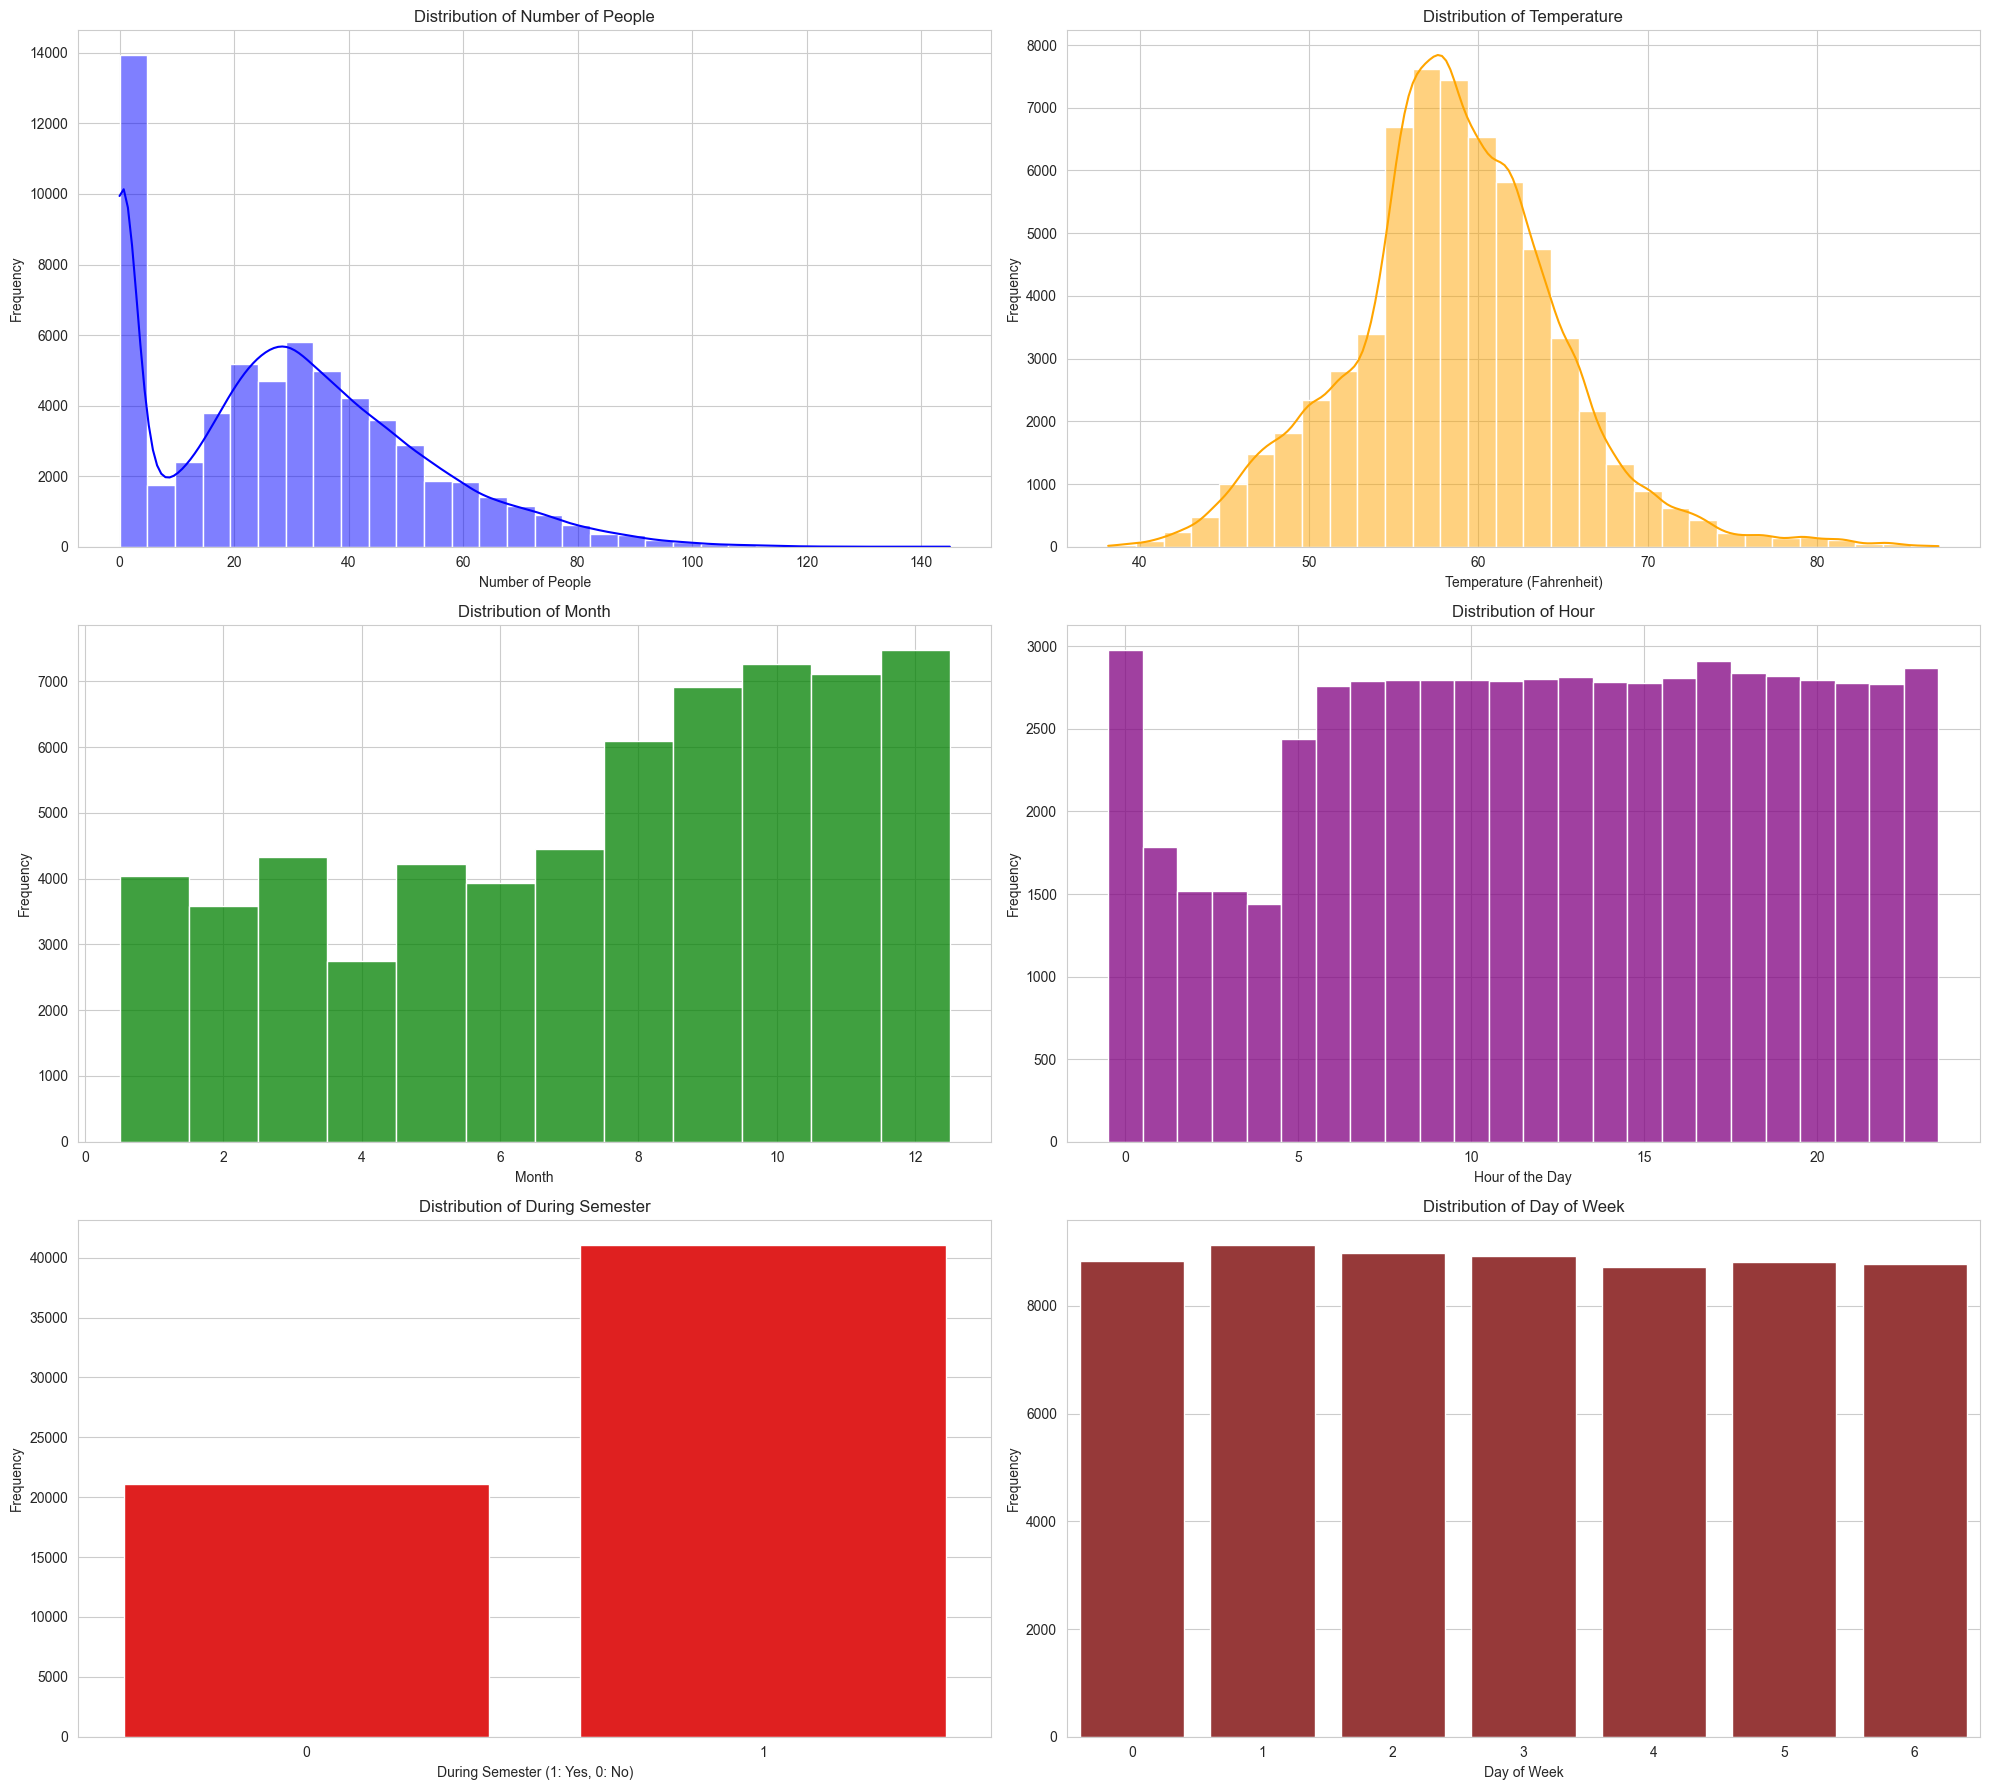

In [19]:
# Create a large figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18))

# Plotting the distribution of `number_people`
sns.histplot(gym_data['number_people'], bins=30, kde=True, color='blue', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Number of People')
axes[0, 0].set_xlabel('Number of People')
axes[0, 0].set_ylabel('Frequency')

# Plotting the distribution of `temperature`
sns.histplot(gym_data['temperature'], bins=30, kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Temperature')
axes[0, 1].set_xlabel('Temperature (Fahrenheit)')
axes[0, 1].set_ylabel('Frequency')

# Plotting the distribution of `month`
sns.histplot(gym_data['month'], bins=12, discrete=True, kde=False, color='green', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Month')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Frequency')

# Plotting the distribution of `hour`
sns.histplot(gym_data['hour'], bins=24, discrete=True, kde=False, color='purple', ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Hour')
axes[1, 1].set_xlabel('Hour of the Day')
axes[1, 1].set_ylabel('Frequency')

# Plotting the distribution of `is_during_semester`
sns.countplot(x='is_during_semester', data=gym_data, color='red', ax=axes[2, 0])
axes[2, 0].set_title('Distribution of During Semester')
axes[2, 0].set_xlabel('During Semester (1: Yes, 0: No)')
axes[2, 0].set_ylabel('Frequency')

# Plotting the distribution of `day_of_week`
sns.countplot(x='day_of_week', data=gym_data, color='brown', ax=axes[2, 1])
axes[2, 1].set_title('Distribution of Day of Week')
axes[2, 1].set_xlabel('Day of Week')
axes[2, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

## Distributions of features
- `number_of_people` shows a skewed distribution, where there's a number of distribution where the gym is empty (0 people)
- `temperature` distribution shows some skew, likely caused by the uneven number of observations in summer and winter months
- `month` distribution indicates substantially more observations from august to december
- `hour` distribution shows consistent observations except between midnight to 4am, where they are reduced.
- `is_during_semester` indicates that two thirds of the observations are in semester time.
- `day_of_week` indicates fairly normal distribution of observations

## Correlations
The number of people is strongly correlated with the `timestamp`, then `temperature`, then `is_during_semester`. To no great surprise, `timestamp` and `hour` are perfectly correlated. Interestingly, there is a slight negative correlation between attendance on a weekend. Suggesting students might travel home or off campus on weekends.

# Cleaning data
We'll want to build a data set that contains only the features we care about or think will predict the number of people well

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

In [21]:
gym_data_clean = gym_data.copy()

columns_to_drop = ['timezone', 'temperature_smooth', 'number_people_smooth', 'shift', 'datetime_pacific', 'is_holiday', 'timestamp', 'date']

gym_data_clean.drop(columns=columns_to_drop, inplace=True)

In [22]:
gym_data_clean['is_holiday_fixed'] = gym_data_clean['is_holiday_fixed'].apply(lambda x: 1 if x else 0)

Since we observed dome decay over time for attendance from the start of the semester, let's add some features to the dataset to track that

In [23]:
# Function to calculate days since the start of the most recent semester
def calculate_days_since_start(datetime, intervals):
    most_recent_days = None  # Store greatest days difference if no match
    for start, _ in intervals:
        difference = (datetime - start).days
        if difference >= 0 and (most_recent_days is None or difference < most_recent_days):
            most_recent_days = difference
    return most_recent_days  # Return days since start of the most recent semester

# Apply the function to create the new column
gym_data_clean['days_since_start_of_semester'] = gym_data_clean['datetime'].apply(
    lambda x: calculate_days_since_start(x, semester_intervals)
)

In [24]:
# Function to calculate days until the start of the next semester
def calculate_days_until_next_semester(datetime, intervals):
    for start, end in sorted(intervals):
        if datetime < start:  # Check if the datetime is before the start of the semester
            return (start - datetime).days
    # If datetime is after all semesters, still return a value
    return float('inf')  # specified numeric infinity or high-backdate timedelta.

# Apply the function to create the new column
gym_data_clean['days_until_next_semester'] = gym_data_clean['datetime'].apply(
    lambda x: calculate_days_until_next_semester(x, semester_intervals)
)

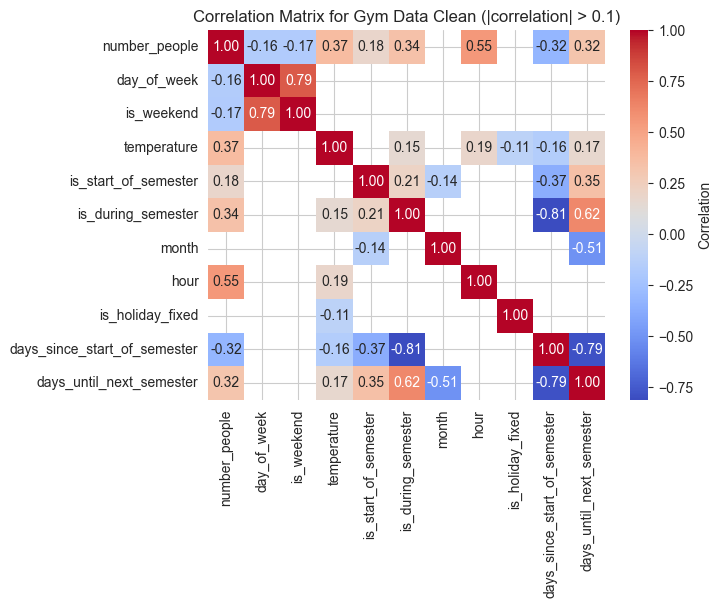

In [25]:
# Display correlation matrix of all numeric columns with correlations greater than 0.1 in absolute value
correlation_matrix_clean = gym_data_clean.select_dtypes(include=[np.number]).corr()

# Create a mask to filter out correlations with absolute values <= 0.1
mask = abs(correlation_matrix_clean) <= 0.1

# Apply the mask before plotting
sns.heatmap(correlation_matrix_clean, annot=True, cmap='coolwarm', fmt=".2f", mask=mask, cbar_kws={"label": "Correlation"})
plt.title('Correlation Matrix for Gym Data Clean (|correlation| > 0.1)')
plt.show()

In [26]:
gym_data_clean.drop(columns=['datetime'], inplace=True)

# Define features and target variable
X = gym_data_clean.drop(columns='number_people')
y = gym_data_clean['number_people']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display the shapes of the training and testing datasets
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

Training features shape: (43528, 10)
Testing features shape: (18656, 10)
Training target shape: (43528,)
Testing target shape: (18656,)


In [27]:
# Create and fit the SGD Regressor to the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Using huber loss function to deal with outliers
sgd_regressor = SGDRegressor(loss='huber', alpha=0.0001, max_iter=10000, tol=1e-3, random_state=42, learning_rate='optimal')
sgd_regressor.fit(X_train_scaled, y_train)

SGDRegressor(learning_rate='optimal', loss='huber', max_iter=10000,
             random_state=42)

In [28]:
# Evaluate the model on the test set
y_pred = sgd_regressor.predict(X_test_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation results
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 252.2084419718269
Mean Absolute Error: 11.998203817239826
R-squared: 0.5106906547820114


In [29]:
# Display the labels and coefficients of the model
print("\nFeature Labels and Coefficients:")
for label, coef in zip(X.columns, sgd_regressor.coef_):
    print(f"{label}: {coef}")


Feature Labels and Coefficients:
day_of_week: -1.4060341238348488
is_weekend: -2.649337097100951
temperature: 4.8734177434649375
is_start_of_semester: 1.763073827087564
is_during_semester: 4.602080119373473
month: -2.5766074386546904
hour: 11.454797692691084
is_holiday_fixed: -1.3278752190677545
days_since_start_of_semester: -0.7177677051693738
days_until_next_semester: -0.354610730920075


# Model performance
The mean absolute error indicates we get the number of people off by about 11, and R2 is only 51.07% correlated. This model is not performing well

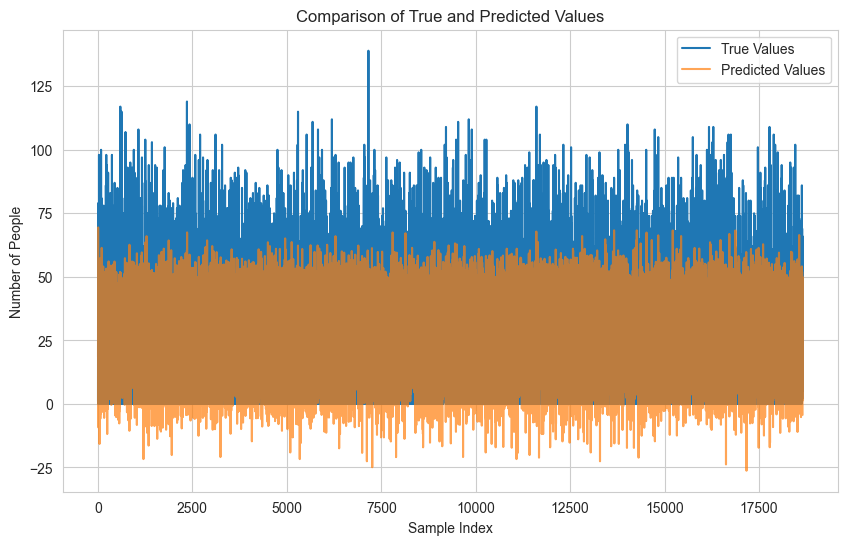

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True Values')
plt.plot(y_pred, label='Predicted Values', alpha=0.7)
plt.title('Comparison of True and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Number of People')
plt.legend()
plt.show()

The model is consistently predicting fewer people attending than actually did. We can try some hyperparameter optimisation, but stochastic gradient descent is probably the wrong tool for this problem.

## Hyperparameter optimisation

In [31]:
### Note this hyperparameter search will take a while ~2 mins on i9-14900K

from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'max_iter': [5000, 10000],
    'tol': [1e-5, 1e-4, 1e-3, 1e-2],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}

# Initialize GridSearchCV with the SGDRegressor and parameter grid for R-squared
grid_search_r2 = GridSearchCV(SGDRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search_r2.fit(X_train_scaled, y_train)

# Print the best parameters and the best R-squared score
print("Best parameters found (R-squared): ", grid_search_r2.best_params_)
print("Best R-squared score: ", grid_search_r2.best_score_)

Best parameters found (R-squared):  {'alpha': 0.001, 'learning_rate': 'adaptive', 'loss': 'squared_epsilon_insensitive', 'max_iter': 5000, 'tol': 0.01}
Best R-squared score:  0.5087081326954114


In [32]:
# Refit the model with the best parameters to extract feature weights
best_r2_model = grid_search_r2.best_estimator_
print("Feature weights with R-squared optimization:")
for feature_name, coef in zip(X_train.columns, best_r2_model.coef_):
    print(f"Feature {feature_name}: {coef}")

Feature weights with R-squared optimization:
Feature day_of_week: -1.7023402148349673
Feature is_weekend: -2.450205577302566
Feature temperature: 5.343533527844952
Feature is_start_of_semester: 1.7713992448531994
Feature is_during_semester: 5.297417396051252
Feature month: -2.8317029627927055
Feature hour: 11.214578707332965
Feature is_holiday_fixed: -1.232444089545743
Feature days_since_start_of_semester: -1.3579067574478991
Feature days_until_next_semester: -0.7495871636954307


# Optimisation results
Even after a fairly lengthy search of the hyperparameter optimisation space ,the delta for R2 initial guess and optimised ones is small only about 0.01

# Model assumptions
Stochastic Gradient Descent assumes a linear relationship between features and target variable, in this case number of people at the gym. We're also encoding variables in time that are cyclical as linear. Let's try some cyclical encoding of them to see how they go

In [33]:
gym_data_clean2 = gym_data_clean.copy()

# Cyclical encoding for 'hour'
gym_data_clean2['hour_sin'] = np.sin(2 * np.pi * gym_data_clean2['hour'] / 24)
gym_data_clean2['hour_cos'] = np.cos(2 * np.pi * gym_data_clean2['hour'] / 24)

# Cyclical encoding for 'month'
gym_data_clean2['month_sin'] = np.sin(2 * np.pi * gym_data_clean2['month'] / 12)
gym_data_clean2['month_cos'] = np.cos(2 * np.pi * gym_data_clean2['month'] / 12)

# Cyclical encoding for 'day_of_week'
gym_data_clean2['day_of_week_sin'] = np.sin(2 * np.pi * gym_data_clean2['day_of_week'] / 7)
gym_data_clean2['day_of_week_cos'] = np.cos(2 * np.pi * gym_data_clean2['day_of_week'] / 7)

In [34]:
# gym_data_clean2.drop(columns=['date', 'datetime', 'timestamp'], inplace=True)

# Define features and target variable
X = gym_data_clean2.drop(columns='number_people')
y = gym_data_clean2['number_people']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing datasets
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

# Create and fit the SGD Regressor to the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Using huber loss function to deal with outliers
sgd_regressor = SGDRegressor(loss='huber', alpha=0.0001, max_iter=10000, tol=1e-3, random_state=42, learning_rate='optimal')
sgd_regressor.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
y_pred = sgd_regressor.predict(X_test_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation results
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

# Model performance

Training features shape: (49747, 16)
Testing features shape: (12437, 16)
Training target shape: (49747,)
Testing target shape: (12437,)
Mean Squared Error: 223.47922661589874
Mean Absolute Error: 11.15198761583454
R-squared: 0.5676110644486165


By moving to cyclical encoding we've improved the R2 and mean absolute error by orders of magnitude more than a hyperparameter search. It is likely this model can be improved by doing some additional feature engineering.

In [35]:
# List and show the coefficients and column names for the new model
print("Coefficients for the updated model with cyclical encoding:")
for feature_name, coef in zip(X_train.columns, sgd_regressor.coef_):
    print(f"Feature {feature_name}: {coef}")

Coefficients for the updated model with cyclical encoding:
Feature day_of_week: -1.244842826799446
Feature is_weekend: -2.375191414456419
Feature temperature: 2.0679367472423924
Feature is_start_of_semester: 1.873380551353402
Feature is_during_semester: 3.7586798735117046
Feature month: -3.403088637455113
Feature hour: 6.8792857336037265
Feature is_holiday_fixed: -1.3278616056331713
Feature days_since_start_of_semester: 2.3009493966985293
Feature days_until_next_semester: 3.783598245610729
Feature hour_sin: -5.63697324747181
Feature hour_cos: -5.115538631013873
Feature month_sin: -2.3410481027074295
Feature month_cos: 1.7850526611580213
Feature day_of_week_sin: 0.12782105631436771
Feature day_of_week_cos: -0.05322578274908795


In [36]:
# Create temporal aggregates
# Calculate average number of people for each hour, and day of the week
hourly_average = gym_data_clean2.groupby('hour')['number_people'].mean().reset_index(name='hourly_average')
daily_average = gym_data_clean2.groupby('day_of_week')['number_people'].mean().reset_index(name='daily_average')

# Merge these aggregates back to the original data
gym_data_clean2_with_aggregates = pd.merge(gym_data_clean2, hourly_average, on='hour', how='left')
gym_data_clean2_with_aggregates = pd.merge(gym_data_clean2_with_aggregates, daily_average, on='day_of_week', how='left')

# Define features and target variable with the new aggregates
X_with_aggregates = gym_data_clean2_with_aggregates.drop(columns='number_people')
y_with_aggregates = gym_data_clean2_with_aggregates['number_people']

# Split the data into training and testing sets
X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(X_with_aggregates, y_with_aggregates, test_size=0.2, random_state=42)

# Scale the data
X_train_agg_scaled = scaler.fit_transform(X_train_agg)
X_test_agg_scaled = scaler.transform(X_test_agg)

# Use the SGD Regressor again with modified inputs
sgd_regressor_agg = SGDRegressor(loss='huber', alpha=0.0001, max_iter=10000, tol=1e-3, random_state=42, learning_rate='optimal')
sgd_regressor_agg.fit(X_train_agg_scaled, y_train_agg)

# Evaluate the new model
y_pred_agg = sgd_regressor_agg.predict(X_test_agg_scaled)

# Calculate evaluation metrics for the new model
mse_agg = mean_squared_error(y_test_agg, y_pred_agg)
mae_agg = mean_absolute_error(y_test_agg, y_pred_agg)
r2_agg = r2_score(y_test_agg, y_pred_agg)

# Print the evaluation results
print("Mean Squared Error (with aggregates):", mse_agg)
print("Mean Absolute Error (with aggregates):", mae_agg)
print("R-squared (with aggregates):", r2_agg)

Mean Squared Error (with aggregates): 200.04001364974124
Mean Absolute Error (with aggregates): 10.432998431019119
R-squared (with aggregates): 0.6129613929693885


By applying some temporal aggregates we've improved the model again. It makes sense since any given gym session might be longer than 1 hour. We don't have enough yearly data and the model is still crude.

# Conclusion
Stochastic Gradient Descent and a hyperparameter search yielded a model to predict gym attendance with an R2 of 0.508. Engineering some cyclical features from the time components and smoothing out the number of people data yielded and R2 of 0.613, a significant improvement

Move improvements could likely be achieved by optimising the feature set of the training data. Given that smoothing out the temporal noise yielded significant improvements, the 10 minute sampling frequency of the data is complicating the fit. Additionally, many of the components going into the training data have some loose correlation in time. Holidays had minimal impact directly, but a field that counted days to next holiday would likely improve it.

## Next steps
### Varying temporal smoothing
Rather than a hyperparameter search, doing a search over the different types of smoothing and seeing what the SGDRegressor comes out with.
### Clustering
There are clearly multiple populations of gym attendance, students vs non students, morning vs night, committed vs uncommitted. Developing a model that has different weightings to represent a linear combination of the different population types. At the very least, we could establish the population that is absent during summer holidays as a proportion of total baseline that's always present.


### Personal note
As this is a study project, I've exceeded my time budget for it. I may revisit it in future